In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from datetime import datetime
from torch import nn
from torch.utils.data import dataloader
from methods import *

In [19]:
data = pd.read_csv("voxmeter.csv")
data

,party_letter,votes,date
0,A,20.3,2025-10-12
1,B,5.2,2025-10-12
2,C,6.2,2025-10-12
3,F,12.6,2025-10-12
4,H,1.5,2025-10-12
...,...,...,...
115,O,8.0,2025-12-14
116,V,11.7,2025-12-14
117,Æ,9.2,2025-12-14
118,Ø,7.0,2025-12-14


,party_letter,votes,date
0,A,20.3,2025-10-12
12,A,20.0,2025-10-19
24,A,21.2,2025-10-26
36,A,21.1,2025-11-02
48,A,21.1,2025-11-09
60,A,19.9,2025-11-16
72,A,19.3,2025-11-23
84,A,19.4,2025-11-30
96,A,18.0,2025-12-07
108,A,18.6,2025-12-14


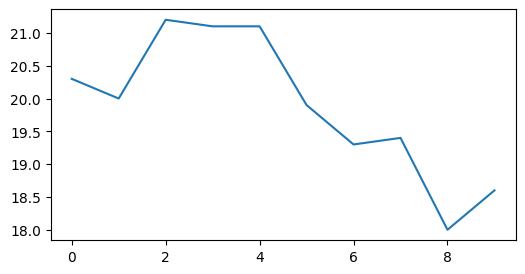

In [20]:
_party = party(data, "A")
data = _party.party_data
votes = data.get("votes").to_list()
display(data)
plt.figure(figsize=[6, 3])
plt.plot(range(len(votes)), votes)
plt.show()

In [21]:
X_train = torch.tensor(votes[:-1])
y_train = torch.tensor(votes[1:])
X_test = torch.tensor(votes[:-1])
y_test = torch.tensor(votes[-1])
print(f"X_train length: {len(X_train)}")
print(f"y_train length: {len(y_train)}")
print(f"X_test length: {X_test.numel()}")
print(f"y_test length: {y_test.numel()}")

X_train length: 9
y_train length: 9
X_test length: 9
y_test length: 1


In [22]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
X, y = create_sequences(X_train.numpy(), seq_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [24]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 2000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Hidden state is reset for each epoch
    outputs, _, _ = model(trainX)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [500/2000], Loss: 1.1734
Epoch [1000/2000], Loss: 0.3236
Epoch [1500/2000], Loss: 0.3091
Epoch [2000/2000], Loss: 0.2321


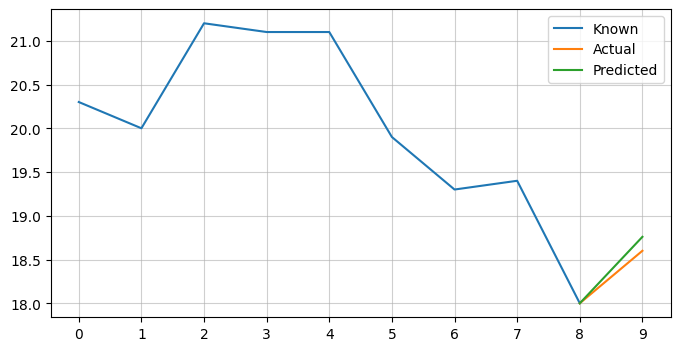

Predicted Vote: 18.76
Actual Vote: 18.60
MAE: 0.160


In [25]:
model.eval()

# Reshape X_test to (Batch Size, Sequence Length, Features)
# Use the last seq_length elements for prediction
testX = X_test[-seq_length:].view(1, -1, 1).float()

with torch.no_grad():
    y_pred, _, _ = model(testX)

plt.figure(figsize=[8, 4])
plt.plot(range(len(X_test)), X_test, label="Known")
plt.plot([len(X_test)-1, len(X_test)], torch.cat([X_test[-1].unsqueeze(0), y_test.unsqueeze(0)]), label="Actual")
plt.plot([len(X_test)-1, len(X_test)], torch.cat([X_test[-1].unsqueeze(0), y_pred.flatten()]), label="Predicted")
plt.xticks(range(len(X_test)+1))
plt.grid(alpha=0.6)
plt.legend()
plt.show()

print(f"Predicted Vote: {y_pred.item():.2f}")
print(f"Actual Vote: {y_test.item():.2f}")
print(f"MAE: {(y_pred.item()-y_test.item()):.3f}")

In [52]:
weeks = (datetime.strptime("2026-04-04", "%Y-%m-%d")-datetime.strptime("2025-12-20", "%Y-%m-%d")).days/7
weeks

15.0